# Ensemble을 이용한 타이타닉 생존자 예측 결과

* pasdas를 사용하여 csv 파일을 컨트롤 해본다.
* ensemble을 구현해본다.
* 타이타닉 문제를 풀어본다.
* 기타  프로젝트 중 직면한 문제를 해결해본다.
    - 학습 중, Error Rate가 Nan이 되는 문제 해결
* 그래프를 그려본다......가 추가되었다..

# 코드 분석

* pasdas를 import 하였습니다.
* anaconda에 pandas를 추가하는 과정을 수행했습니다....--;;

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time

### Loading Data

In [2]:
train = pd.read_csv("./data/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_y = train['Survived']
train_y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [4]:
train_x = train.drop(labels='Survived', axis=1)
train_x.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_x  = pd.read_csv("./data/test.csv")
test_x.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### TINANIC Class

In [6]:
class TITANIC:
        
    def __init__(self):
        print("Created Titanic Object!")
    
    ############ Loading Data ############
    
    def load_train_data(self, cvs_file_path):
        
        ## pandas csv load
        self.train_data = pd.read_csv(cvs_file_path)
                
        self.train_y_data = self.train_data['Survived']
        self.train_y = self.train_y_data.reshape(-1,1)
        
        # Logistic Regression 이므로 onehot은 필요없다.
        # self.train_y_onehot = pd.get_dummies(self.train_y)
        
        self.train_x = self.train_data.drop(labels='Survived', axis=1)
        
    def load_test_data(self, cvs_file_path):
        
        ## pandas cvs load
        self.test_data  = pd.read_csv(cvs_file_path)
    
    ############ Normalize Data ############
    
    # list의 최대값, 최소값을 받아서 0~1 사이의 값으로 바꾼다.
    def normalize_data(self, data_list, data):
        
        '''
        # 정규분포로 바꾼다.
        data_avr = np.mean(data_list)
        data_std = np.std(data_list)
        
        data_normal = (data_list-data_avr)/data_std
        '''
        
        data_normal = data_list
        max_value = np.max(data_normal)
        min_value = np.min(data_normal)
        data_normal = (data_normal-min_value)/(max_value-min_value)
        
        if data.size == 2:
            data = data_normal
        else:
            data = np.vstack( (data, data_normal) )
            
        return data
    
    ## 데이터가 영문 단어일 경우 처리!
    def normalize_char_data(self, data_list, data):
        
        # print(data_list.size)
        temp_data = np.zeros([data_list.size], dtype=np.float32)
        # print(temp_data.shape)
        for i in range(data_list.size):
            # SEX
            if data_list[i]=='male':
                temp_data[i] = 0
            elif data_list[i]=='female':
                temp_data[i] = 1
            # Embarked
            elif data_list[i]=='S':
                temp_data[i] = 0
            elif data_list[i]=='C':
                temp_data[i] = 1
            elif data_list[i]=='Q':
                temp_data[i] = 2
            # ETC
            else:
                temp_data[i] = 0
        
        data = self.normalize_data(temp_data, data)
        
        return data
    
    def normalize_ticket_data(self, data_list, data):
        
        temp_data = []
        
        # 일단 ticket data에서 맨 뒷자리 공백까지의 숫자를 가져온다.
        for i in range(data_list.size):
            first_index = data_list[i].rfind(" ")+1
            temp_data.append(data_list[i][first_index:])
        
        # "LINE" 처리
        length_list = np.zeros([len(temp_data)], dtype=np.int32)
        for i in range(len(temp_data)):
            if temp_data[i] == "LINE":
                temp_data[i] = "00"
        
        # 티켓 번호의 자리수 분석
        length_list = np.zeros([len(temp_data)], dtype=np.int32)
        for i in range(len(temp_data)):
            length_list[i] = len(temp_data[i])
        
        data = self.normalize_data(length_list, data)
        
        # 티켓 번호의 맨 앞자리수 분석
        first_char_list = np.zeros([len(temp_data)], dtype=np.int32)
        for i in range(len(temp_data)):
            first_char_list[i] = (int)(temp_data[i][0])
        
        data = self.normalize_data(length_list, data)
        
        return data
    
    def normalize_cabin_data(self, data_list, data):
        
        temp_data = []
        # cabin의 앞자리 문자를 가져온다.
        for i in range(data_list.size):
            temp_data.append(data_list[i][0])
        
        cabin_list = np.zeros([len(temp_data)], dtype=np.int32)
        for i in range(len(temp_data)):
            
            if temp_data[i]=='A':
                cabin_list[i] = 1
            elif temp_data[i]=='B':
                cabin_list[i] = 2
            elif temp_data[i]=='C':
                cabin_list[i] = 3
            elif temp_data[i]=='D':
                cabin_list[i] = 4
            elif temp_data[i]=='E':
                cabin_list[i] = 5
            elif temp_data[i]=='F':
                cabin_list[i] = 6
            elif temp_data[i]=='G':
                cabin_list[i] = 7
            elif temp_data[i]=='T':
                cabin_list[i] = 8
            else:
                cabin_list[i] = 0
        
        data = self.normalize_data(cabin_list, data)
        
        return data
    
    def make_analysis_data(self, csv_data):
        
        data = np.array([0, 0], dtype=np.float32);
        
        #### BLANK 처리를 추가해야한다 ####
        #### 기본적으로는 -1이 괜찮나? 0과 구분이 되기만 하면 된다. ####
        
        data = self.normalize_data(csv_data['Pclass'], data)
        data = self.normalize_char_data(csv_data['Sex'], data)
        data = self.normalize_data(csv_data['Age'].fillna(-1), data)
        data = self.normalize_data(csv_data['SibSp'], data)
        data = self.normalize_data(csv_data['Parch'], data)
        # TICKET
        data = self.normalize_ticket_data(csv_data['Ticket'], data)
        data = self.normalize_data(csv_data['Fare'], data)
        # CABIN
        data = self.normalize_cabin_data(csv_data['Cabin'].fillna(' '), data)
        data = self.normalize_char_data(csv_data['Embarked'].fillna(-1), data)
        
        data = data.transpose()
        
        return data
    
    def next_batch(self, x_data, y_data, batch_size):
        # random int를 갯수만큼 수행하여 해당 index의 X와 Y를 리턴한다.
        sample_indices = np.random.randint(0, len(y_data), size=batch_size)
        return x_data[sample_indices, :], y_data[sample_indices, :]
      
        ############ Training Data ############
        
    def train_old(self, x_data, y_data, x_data_test, batch_size, traing_epoch):
        
        # construct network
        X = tf.placeholder(tf.float32, [None, 10])
        Y = tf.placeholder(tf.float32, [None, 1])
        keep_prob = tf.placeholder(tf.float32)
        
        
        num_of_weight = 100
        with tf.variable_scope("L1", reuse=tf.AUTO_REUSE):
            W1 = tf.get_variable("W1", shape=[10, num_of_weight], initializer=tf.contrib.layers.xavier_initializer())
            b1 = tf.Variable(tf.random_normal([num_of_weight]), dtype=tf.float32, name = 'b1')
            L1 = tf.nn.relu( tf.matmul(X, W1) + b1)
            L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
        
        with tf.variable_scope("L2", reuse=tf.AUTO_REUSE):
            W2 = tf.get_variable("W2", shape=[num_of_weight, num_of_weight], initializer=tf.contrib.layers.xavier_initializer())
            b2 = tf.Variable(tf.random_normal([num_of_weight]), dtype=tf.float32, name='b2')
            L2 = tf.nn.relu( tf.matmul(L1, W2) + b2)
            L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

        with tf.variable_scope("L3", reuse=tf.AUTO_REUSE):
            W3 = tf.get_variable("W3", shape=[num_of_weight, num_of_weight], initializer=tf.contrib.layers.xavier_initializer())
            b3 = tf.Variable(tf.random_normal([num_of_weight]), dtype=tf.float32, name='b3')
            L3 = tf.nn.relu( tf.matmul(L2, W3) + b3)
            L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
        
        with tf.variable_scope("L4", reuse=tf.AUTO_REUSE):
            W4 = tf.get_variable("W4", shape=[num_of_weight, num_of_weight], initializer=tf.contrib.layers.xavier_initializer())
            b4 = tf.Variable(tf.random_normal([num_of_weight]), dtype=tf.float32, name='b4')
            L4 = tf.nn.relu( tf.matmul(L3, W4) + b4)
            L4 = tf.nn.dropout(L4, keep_prob=keep_prob)        
        
        with tf.variable_scope("LF", reuse=tf.AUTO_REUSE):
            WF = tf.get_variable("WF", shape=[num_of_weight, 1], initializer=tf.contrib.layers.xavier_initializer())
            bF = tf.Variable(tf.random_normal([1]), dtype=tf.float32, name='bF')
        
        with tf.variable_scope("Cal", reuse=tf.AUTO_REUSE):    
            hypothesis = tf.sigmoid( tf.matmul(L4, WF) + bF)
            # cost/loss function
            cost = - tf.reduce_mean(Y*tf.log(hypothesis)+(1-Y)*tf.log(1-hypothesis))
        
       # 이후는 동일
        
        
    def train(self, x_data, y_data, x_data_test, batch_size, traing_epoch):
        
        # construct network
        X = tf.placeholder(tf.float32, [None, 10])
        Y = tf.placeholder(tf.float32, [None, 1])
        keep_prob = tf.placeholder(tf.float32)
        
        num_of_node = 100
        iscale = 0.01
        
        with tf.variable_scope('EasyNet', reuse=tf.AUTO_REUSE):
          L1 = tf.contrib.layers.fully_connected(X, num_of_node, weights_regularizer=tf.contrib.layers.l2_regularizer(scale=iscale))
          L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

          L2 = tf.contrib.layers.fully_connected(L1, num_of_node, weights_regularizer=tf.contrib.layers.l2_regularizer(scale=iscale))
          L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

          L3 = tf.contrib.layers.fully_connected(L2, num_of_node, weights_regularizer=tf.contrib.layers.l2_regularizer(scale=iscale))
          L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

          L4 = tf.contrib.layers.fully_connected(L3, 1, weights_regularizer=tf.contrib.layers.l2_regularizer(scale=iscale))
        
        with tf.variable_scope('Training', reuse=tf.AUTO_REUSE):
          logit = tf.layers.dense(L4, 1)
          hypothesis = tf.nn.sigmoid(logit)
          
          reg_ws = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'EasyNet')
          cost = tf.losses.sigmoid_cross_entropy(Y, logit) + tf.reduce_sum(reg_ws)
        
          # define gradient
          gradient = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

        # Accuracy Computation
        predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32 ))

        # init network
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        
        start_time = time.time()
        for epoch in range(traing_epoch):
            avg_cost = 0.0
            total_batch = int(len(y_data)/batch_size)
            for batch in range(total_batch):
                batch_X, batch_Y = self.next_batch(x_data, y_data, batch_size)
                cost_, _ = sess.run([cost, gradient], feed_dict={X: batch_X, Y:batch_Y, keep_prob:0.7})
                avg_cost += cost_/total_batch
            
            if epoch%100 == 0:
                print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
        
        end_time = time.time()
        print('Learning Time = ', end_time-start_time)
        
        # write result
        print( sess.run([accuracy], feed_dict={X: x_data, Y: y_data, keep_prob:1.0}) )
        
        predict = sess.run(hypothesis, feed_dict={X: x_data_test, keep_prob:1.0})
        # np.savetxt("./predict.csv", predict, delimiter=",")
        
        
        sess.close()
        
        return predict
    
    ############ Ensemble ############
    
    def get_result_ensemble(self, en_data):
        avr_data = np.average(en_data, axis=1)
        print(avr_data.shape)
        
        # Accuracy Computation
        # predicted = np.cast(avr_data > 0.5, dtype=tf.int32)
        predict = np.int32((avr_data > 0.5))
        print(predict)
        
        np.savetxt("./predict.csv", predict, delimiter=",")
        # accuracy = np.reduce_mean(np.cast(np.equal(predicted, Y), dtype=np.float32 ))
    

### Execute Code - Load_Data

In [7]:
# 3. Loading Data & Analyze Data    
titanic = TITANIC()
train_dataX = titanic.make_analysis_data(train_x)
print("train_dataX.shape = ", train_dataX.shape)

test_dataX  = titanic.make_analysis_data(test_x)
print("train_dataX.shape = ", test_dataX.shape)


Created Titanic Object!
train_dataX.shape =  (891, 10)
train_dataX.shape =  (418, 10)


### Execute Code - Train_Data

In [11]:
# 4. Execute Ensemble Data
ensembleSize = 10
train_dataY = train_y.values.reshape(-1,1)

for i in range(ensembleSize):
    train_result = titanic.train(train_dataX, train_dataY, test_dataX, 200, 200)
    
    if i==0:
        train_result_en = train_result
    else:
        train_result_en = np.hstack( (train_result_en, train_result) )
        
        
# print(train_result_en)
titanic.get_result_ensemble(train_result_en)

Epoch: 0001 cost = 1.785382837
Epoch: 0101 cost = 1.201984555
Learning Time =  2.2961087226867676
[0.7979798]
Epoch: 0001 cost = 1.800774872
Epoch: 0101 cost = 1.234439552
Learning Time =  2.092566728591919
[0.7631874]
Epoch: 0001 cost = 1.797257304
Epoch: 0101 cost = 1.223364294
Learning Time =  2.0734970569610596
[0.7856341]
Epoch: 0001 cost = 1.781733662
Epoch: 0101 cost = 1.211535096
Learning Time =  2.0714848041534424
[0.78338945]
Epoch: 0001 cost = 1.801866591
Epoch: 0101 cost = 1.201474845
Learning Time =  2.1506941318511963
[0.7957351]
Epoch: 0001 cost = 1.789952576
Epoch: 0101 cost = 1.186721474
Learning Time =  2.24898362159729
[0.8069585]
Epoch: 0001 cost = 1.796429366
Epoch: 0101 cost = 1.113067210
Learning Time =  2.0935678482055664
[0.8148148]
Epoch: 0001 cost = 1.777995437
Epoch: 0101 cost = 1.177862912
Learning Time =  2.2128870487213135
[0.81257015]
Epoch: 0001 cost = 1.791907430
Epoch: 0101 cost = 1.190076053
Learning Time =  2.077526807785034
[0.8148148]
Epoch: 0001 

D:\ProgramFiles\Anaconda3\envs\tc\lib\site-packages\ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in greater


### Kaggle Score

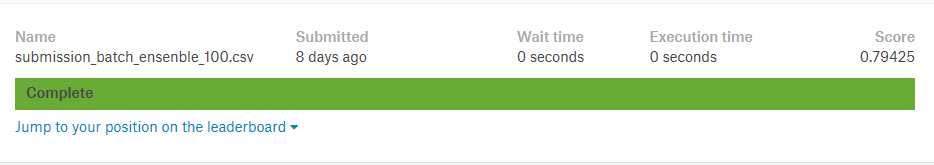